In [1]:
import os
import numpy as np
import pandas as pd
import ktrain
from sklearn.datasets import fetch_20newsgroups

c:\Coding\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 데이터 확보

In [2]:
from pymongo import MongoClient
# from dotenv import load_dotenv
import os

# load_dotenv(verbose=True,dotenv_path='./env')

# mongoDB 설정
mongo_host = "localhost"
mongo_port = 27020
mongo_user = "churros"
mongo_passwd = "A503"
mongo_db_name = "newsdb"
mongo_client = MongoClient(host=mongo_host, port=mongo_port, username=mongo_user, password=mongo_passwd)


db = mongo_client[mongo_db_name]
collection = db['newsCol']

In [3]:
# 예시용 데이터
remove = ('headers', 'footers', 'quotes')
train = fetch_20newsgroups(subset='train', remove=remove)
test = fetch_20newsgroups(subset='test', remove=remove)

texts = train.data + test.data

## Ktrain 을 활용한 topic model 로 추천

In [4]:
data = list(collection.find())
texts = list(i["full_text"] for i in data)

In [5]:
tm = ktrain.text.get_topic_model(texts, n_features=10000)

n_topics automatically set to 116
lang: ko
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [6]:
tm.build(texts, threshold=0.25)

done.


In [7]:
tm.train_recommender()

In [8]:
rawtext = "이게 잘 되는지 내가 어덯게 아냐"

In [9]:
tm.recommend(text=rawtext, n=5)

[{'text': '넷플릭스 히트작 \'기묘한 이야기\' 시리즈에 출연한 배우 그레이스 반 디엔이 성추행 피해를 호소, 돌연 연예계 활동을 중단했다.9일(현지 시간) 미국 연예매체 버라이어티(Variety)에 따르면 넷플릭스 \'기묘한 이야기 4\'에서 크리시 커닝햄 역으로 활약한 배우 그레이스 반 디엔이 영화 제작자로부터 성추행을 당했다고 주장한 이후 모든 배역을 거절하고 있다. 그레이스 반 디엔은 지난 2주 동안 4개의 영화의 캐스팅 제의를 거절했다며 현재 집에서 트위치 스트리밍 방송을 하는 것에 더 집중할 것이라고 밝혔다. 그는 "내가 배역을 모두 거절한 것에 대해 일부 사람들이 화를 내는 것을 봤다. 하지만 그들이 알아야 할 사실은 내가 최근 작업한 마지막 몇 개의 프로젝트에서 최악의 경험을 했다는 것이다"라고 설명했다.그레이스 반 디엔은 한 영화 제작자가 촬영장에서 자신에게 원치 않는 성적인 접근을 했다고 주장했다. 그는 "마지막으로 촬영한 영화 중 한 제작자가 여러 명과 같이 성관계를 할 것을 요구했다"며 "그는 내 상사이다. 나는 울지 않으려고 애썼지만 힘들었다"라고 털어놓았다. 또한 집에서 스트리밍 방송을 하는 것이 과연 더 좋을지 의문을 품는 사람들에게는 "나는 내 집에 머물며 비디오 게임을 할 수 있고 상사가 나에게 잠자리를 요구하지 않는다"고 전했다.그는 "나는 이곳에서 행복하고 나만의 프로젝트를 개발하고 있다"라며 "누군가 나에게 자금을 지원해 주길 바라고 있다. 그러면 내가 내 촬영장을 직접 관리할 수 있고 배우들에게 잠자리를 요청하지 않아도 되기 때문이다"라고 자신을 성추행한 제작자에게 일침을 가했다.마지막으로 그레이스 반 디엔은 지금은 비록 휴식기를 갖고 있지만 언젠가 자신의 방식으로 연예계에 복귀할 것을 희망한다고 덧붙였다. 한편 배우 그레이스 반 디엔은 96년생으로 올해 26세이다. 최근 넷플릭스 오리지널 드라마 \'기묘한 이야기 4\'에서 얼굴을 비췄으며 2014년 \'잠자는 숲속의 미녀와 야수\'에서 공주 역을 맡기도 했다.또

## gensim library 를 활용한 LDA

### 전처리

In [10]:
from konlpy.tag import  Komoran
# 형태소 분석 library import
kom = Komoran()
# komoran은 빈줄이 있으면 에러가 남
# komoran.morphs("\n".join([s for s in c[:40].split("\n") if s]))

In [11]:
# 중복 반복되는 단어 정규화
# from soynlp.normalizer import *
# repeat_normalize('와하하하하하하하하하핫', num_repeats=2)

In [12]:
# mecab = Mecab()
from tqdm import tqdm # 작업 프로세스 시각화
import re # 문자열 처리를 위한 정규표현식 패키지
from gensim import corpora # 단어 빈도수 계산 패키지
from collections import Counter # 단어 등장 횟수 카운트
import pandas as pd

In [13]:
df_raw = pd.DataFrame(data)

In [14]:
# 결측치 제거 (형태소 분석 진행시 null값이 존재하면 오류 발생)
df = df_raw.dropna(axis = 0)


In [15]:
# 분석에서 제외할 데이터 제거
df.reset_index(drop = True, inplace=True) # 인덱스 초기화

In [16]:
# 토큰화 이전 불필요한 글자들 전처리
# punctuation 삭제
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', } 
def clean(text):
    for p in punct_mapping:
        text = text.replace(p, punct_mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()

# 불필요한 부분 삭제(이메일, url등)
def clean_str(text):
    pattern = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'[^\w\s\n]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    text = re.sub(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', string=text)
    text = re.sub(r'\n', '.', string=text)
    return text 


동사를 원형으로 복원하도록 하겠습니다. 규칙은 다음과 같습니다.

1. NNG|NNP|NNB + XSV|XSA --> NNG|NNP|NNB + XSV|XSA + 다
2. NNG|NNP|NNB + XSA + VX --> NNG|NNP + XSA + 다
3. VV --> VV + 다
4. VX --> VX + 다

In [17]:
# 동사 원형 복원
p1 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XS.')
p2 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XSA [가-힣A-Za-z0-9]+/VX')
p3 = re.compile('[가-힣A-Za-z0-9]+/VV')
p4 = re.compile('[가-힣A-Za-z0-9]+/VX')
def stemming_text(text):
    corpus = []
    for sent in text:
        ori_sent = sent
        mached_terms = re.findall(p1, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        
        mached_terms = re.findall(p2, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                if tag != 'VX':
                    modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p3, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p4, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        corpus.append((ori_sent))
    return corpus

In [18]:
# 불용어 제거 및 특정 품사만 살리기
word_file = open("stopwords.txt", "r", encoding="utf-8")
words = word_file.read()
stop_words = set(words.split('\n'))
lemmatization = {"VV","VX","NNG","NNP","NNB","XSV","XSA","SL","XR","SN","SH","SW","MAG","NF"}

def token(txt):
    txt = clean(txt)
    txt = clean_str(txt)
    word_tokens = kom.pos(txt, join="/")
    cleared = [word for word in word_tokens if (not (word.split('/')[0] in stop_words) and word.split('/')[1] in lemmatization)]
    result = stemming_text(cleared)
    return result
df["token"] = df["full_text"].apply(token)

In [19]:
print(df.token.head())

0    [창원/NNP, 연합뉴스/NNP, 임헌정/NNP, 기자/NNG, 윤석열/NNP, 대...
1    [창원/NNP, 연합뉴스/NNP, 임헌정/NNP, 기자/NNG, 윤석열/NNP, 대...
2    [창원/NNP, 뉴시스/NNP, 전신/NNP, 기자/NNG, 윤석열/NNP, 대통령...
3    [창원/NNP, 뉴시스/NNP, 전신/NNP, 기자/NNG, 윤석열/NNP, 대통령...
4    [창원/NNP, 뉴시스/NNP, 전신/NNP, 기자/NNG, 윤석열/NNP, 대통령...
Name: token, dtype: object


### Gensim corpora model
- 참고 [link](https://wikidocs.net/30708)

In [20]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(df.token)
corpus = [dictionary.doc2bow(text) for text in df.token]


In [21]:
print(corpus[1])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]


In [22]:
print(dictionary[66])

제보/NNG


In [23]:
len(dictionary)

60993

In [24]:
import gensim
NUM_TOPICS = 30 # 30개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(26, '0.046*"노조/NNG" + 0.024*"회장/NNG" + 0.016*"고용/NNP" + 0.015*"민주노총/NNP"')
(0, '0.056*"대표/NNG" + 0.022*"의원/NNG" + 0.015*"있다/VV" + 0.015*"힘/NNG"')
(1, '0.025*"지원/NNG" + 0.021*"위하다/VV" + 0.015*"지역/NNG" + 0.012*"되/XSV"')
(23, '0.041*"교육/NNG" + 0.029*"학교/NNG" + 0.024*"학생/NNG" + 0.018*"교육청/NNG"')
(12, '0.020*"중국/NNP" + 0.016*"수출/NNG" + 0.016*"수소/NNP" + 0.012*"되/XSV"')
(2, '0.044*"카카오/NNP" + 0.019*"하이브/NNP" + 0.019*"있다/VV" + 0.018*"SM/SL"')
(15, '0.028*"기업/NNG" + 0.014*"사업/NNG" + 0.014*"있다/VV" + 0.014*"위하다/VV"')
(9, '0.024*"되/XSV" + 0.024*"대전/NNP" + 0.022*"있다/VV" + 0.021*"화재/NNP"')
(10, '0.021*"있다/VV" + 0.017*"근로/NNG" + 0.016*"되/XSV" + 0.012*"수/NNB"')
(20, '0.055*"14/SN" + 0.052*"서울/NNP" + 0.046*"기자/NNG" + 0.031*"2023/SN"')
(8, '0.034*"씨/NNB" + 0.021*"되/XSV" + 0.017*"A/SL" + 0.015*"있다/VV"')
(25, '0.018*"\xa0/SW" + 0.016*"있다/VV" + 0.016*"kr/SL" + 0.015*"제보/NNG"')
(11, '0.031*"\xa0/SW" + 0.025*"있다/VV" + 0.016*"되다/VV" + 0.011*"보다/VV"')
(19, '0.044*"1/SN" + 0.025*"2/SN" + 0.023*"3/SN" + 0.021*"

In [25]:
print(ldamodel.print_topics())

[(2, '0.044*"카카오/NNP" + 0.019*"하이브/NNP" + 0.019*"있다/VV" + 0.018*"SM/SL" + 0.015*"지분/NNG" + 0.015*"김새론/NNP" + 0.012*"네이버/NNP" + 0.011*"되/XSV" + 0.009*"플랫폼/NNP" + 0.009*"인수/NNG"'), (5, '0.024*"있다/VV" + 0.023*"SVB/SL" + 0.022*"은행/NNG" + 0.018*"미국/NNP" + 0.018*"금융/NNG" + 0.015*"되/XSV" + 0.011*"시장/NNG" + 0.010*"금리/NNG" + 0.009*"사태/NNG" + 0.009*"파산/NNP"'), (24, '0.019*"있다/VV" + 0.013*"수/NNB" + 0.013*"되/XSV" + 0.010*"제공/NNG" + 0.009*"진행/NNG" + 0.009*"다양/XR" + 0.008*"행사/NNG" + 0.008*"점/NNB" + 0.008*"밝히다/VV" + 0.007*"14/SN"'), (11, '0.031*"\xa0/SW" + 0.025*"있다/VV" + 0.016*"되다/VV" + 0.011*"보다/VV" + 0.011*"주다/VV" + 0.010*"되/XSV" + 0.009*"않다/VV" + 0.009*"수/NNB" + 0.008*"라고/NNP" + 0.008*"사람/NNG"'), (28, '0.024*"주택/NNG" + 0.023*"되/XSV" + 0.021*"있다/VV" + 0.012*"서울/NNP" + 0.012*"1/SN" + 0.011*"아파트/NNG" + 0.011*"가구/NNP" + 0.010*"2/SN" + 0.007*"입주/NNG" + 0.007*"국토/NNP"'), (23, '0.041*"교육/NNG" + 0.029*"학교/NNG" + 0.024*"학생/NNG" + 0.018*"교육청/NNG" + 0.014*"명/NNB" + 0.013*"있다/VV" + 0.011*"서울/NNP" + 0.010*"대학

In [26]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

### Optimal Topic Number Determining
- 참고 [link](https://humboldt-wi.github.io/blog/research/information_systems_1819/is_lda_final/)

In [159]:
import random
topicnums = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70]
project_folder = os.getcwd()

ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    if not os.path.exists(project_folder+'\\models\\ldamodels_bow_'+str(i)+'.lda'):
        %time ldamodels_bow[i] = models.LdaModel(corpus, num_topics=i, random_state=42, update_every=1, passes=10, id2word=dictionary)
        ldamodels_bow[i].save(project_folder+'\\models\\ldamodels_bow_'+str(i)+'.lda')
        print('ldamodels_bow_{}.lda created.'.format(i))
    else: 
        print('ldamodels_bow_{}.lda already exists.'.format(i))

ldamodels_bow_1.lda already exists.
ldamodels_bow_5.lda already exists.
ldamodels_bow_10.lda already exists.
ldamodels_bow_15.lda already exists.
ldamodels_bow_20.lda already exists.
ldamodels_bow_25.lda already exists.
ldamodels_bow_30.lda already exists.
ldamodels_bow_35.lda already exists.
ldamodels_bow_40.lda already exists.
ldamodels_bow_45.lda already exists.
ldamodels_bow_50.lda already exists.
CPU times: total: 20min 12s
Wall time: 16min 58s
ldamodels_bow_55.lda created.
CPU times: total: 22min 24s
Wall time: 18min 13s
ldamodels_bow_60.lda created.
CPU times: total: 27min
Wall time: 21min 50s
ldamodels_bow_65.lda created.


In [28]:
lda_topics = {}
for i in topicnums:
    lda_model = models.LdaModel.load(project_folder+'/models/ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

In [29]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

In [30]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims

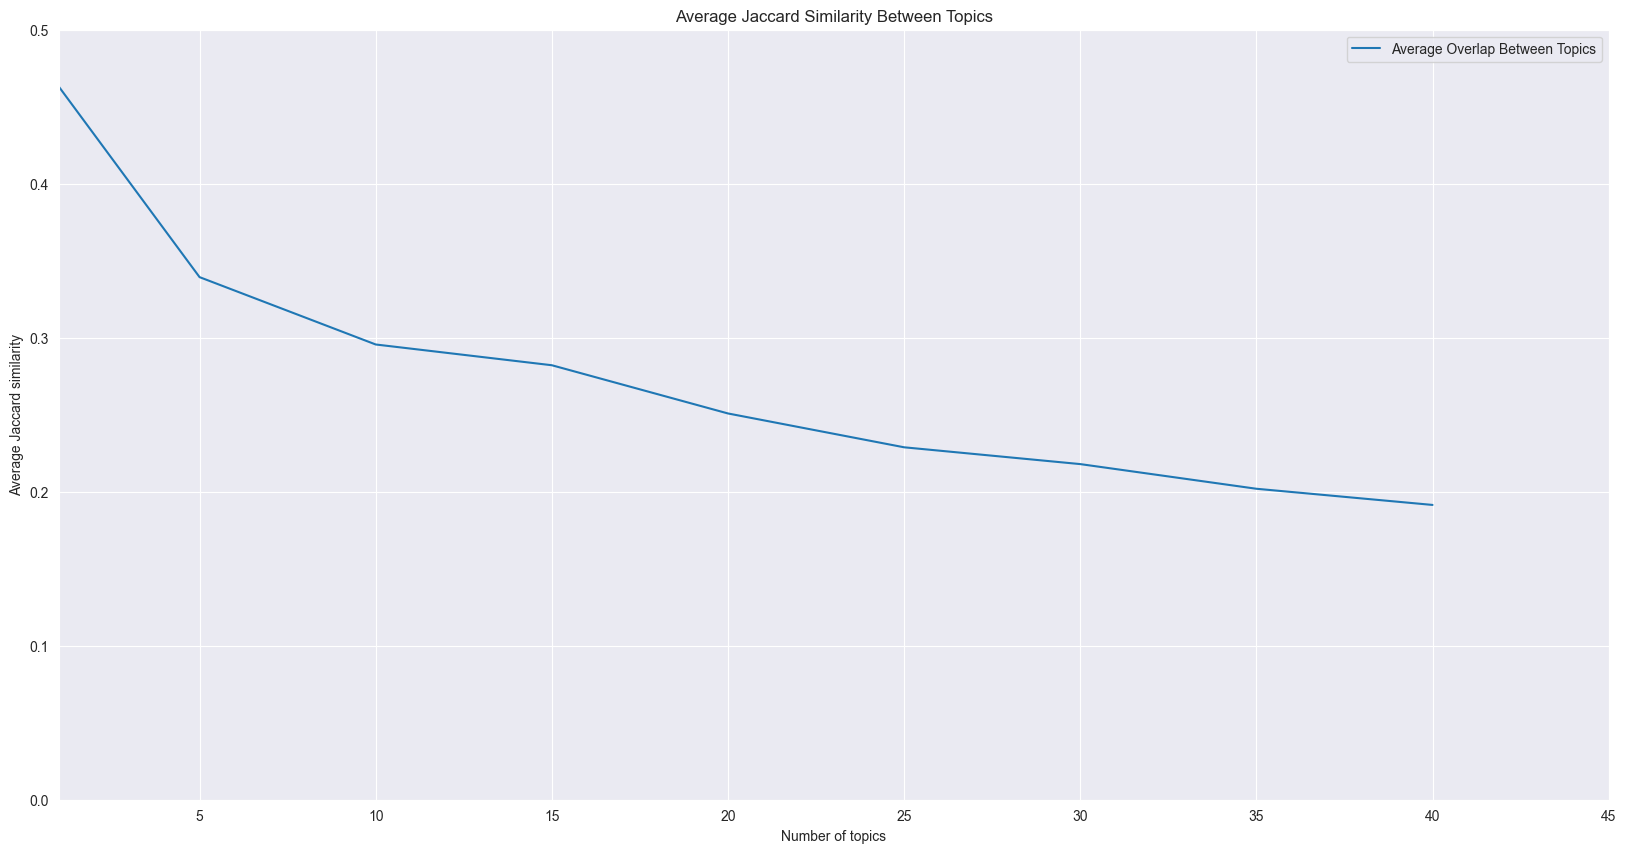

In [37]:
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.figure(figsize=(20,10))
    plt.plot(x,y,label='Average Overlap Between Topics')
    plt.xlim([1, 45])
    plt.ylim([0, 0.5])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')   
    plt.title('Average Jaccard Similarity Between Topics')
    plt.legend()    
    plt.show()

### 추천 진행

In [39]:
num_topics = 40
lda_model_final = models.LdaModel.load(project_folder+'/models/ldamodels_bow_'+str(num_topics)+'.lda')
corpus_lda_model = lda_model_final[corpus]

In [112]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_final, corpus, dictionary)
pyLDAvis.display(vis)

In [49]:
# %%cache mycache_lda_index.pkl index
index = similarities.MatrixSimilarity(lda_model_final[corpus])

In [128]:
def book_recommender(idx):
    books_checked = 0
    for i in range(len(df.token)):
        recommendation_scores = []
        if i == idx:
            lda_vectors = corpus_lda_model[i]
            print("아마도 한개의 벡터",lda_vectors)
            sims = index[lda_vectors]
            sims = list(enumerate(sims))
            for sim in sims:
                book_num = sim[0]
                recommendation_score = [df.title[book_num], sim[1],df["_idx"][book_num],]
                recommendation_scores.append(recommendation_score)
            
            recommendation = sorted(recommendation_scores, key=lambda x: x[1], reverse=True)
            print("Your article's most prominent tokens are:")
            article_tokens = corpus[i]
            sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True)
            sorted_tokens_10 = sorted_tokens[:10]
            for i in range(len(sorted_tokens_10)):
                print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                             dictionary[sorted_tokens_10[i][0]], 
                                                             sorted_tokens_10[i][1]))
            print('-----')
            print("Your article's most prominant topic is:")
            print(lda_model_final.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
            print('-----')
            print('Here are your recommendations for "{}":'.format(idx))
            display(recommendation[1:11])
        
        else:
            books_checked +=1
            

In [129]:
book_recommender(300)

아마도 한개의 벡터 [(7, 0.013402284), (10, 0.03166829), (14, 0.032272898), (16, 0.015153514), (17, 0.03338314), (22, 0.08283149), (23, 0.3799801), (24, 0.018304564), (25, 0.057385556), (26, 0.022226851), (27, 0.2305493), (29, 0.06948714), (33, 0.010523252)]
Your article's most prominent tokens are:
Word 10308 ("아이파크몰/NNP") appears 9 time(s).
Word 596 ("점/NNB") appears 8 time(s).
Word 10311 ("척/NNP") appears 8 time(s).
Word 1284 ("지역/NNG") appears 6 time(s).
Word 10285 ("개점/NNG") appears 5 time(s).
Word 10287 ("구로구/NNP") appears 5 time(s).
Word 773 ("식/NNB") appears 4 time(s).
Word 1229 ("동/NNP") appears 4 time(s).
Word 10283 ("HDC/SL") appears 4 time(s).
Word 0 ("10/SN") appears 3 time(s).
-----
Your article's most prominant topic is:
0.016*"있다/VV" + 0.013*"점/NNB" + 0.011*"제품/NNG" + 0.009*"상품/NNG" + 0.009*"브랜드/NNP" + 0.009*"수/NNB" + 0.009*"되/XSV" + 0.009*"판매/NNG" + 0.008*"고객/NNG" + 0.008*"진행/NNG"
-----
Here are your recommendations for "300":


[['"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', 0.99999994, 878],
 ['"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', 0.9999999, 994],
 ['“적립금 줄게요”… ‘비계 잔뜩’ 삼겹살이 불러온 후폭풍', 0.9454536, 23529],
 ['‘비계 삼겹살’ 논란에 유통업계, 검수 늘리고 교환·환불키로', 0.9412119, 10416],
 ['비계인지 삼겹살인지 긴가민가… 유통업계 "품질관리하겠다"', 0.93948483, 12291],
 ['아이파크몰 고척점, 누적 방문객수 170만 명 돌파', 0.9381969, 5254],
 ["'비계 삼겹살' 후폭풍…유통업계, 교환·환불에 검수 강화", 0.92265946, 11910],
 ['‘비계덩어리’ 삼겹살 논란에 뜨끔...유통업체 내놓은 해결책이', 0.9195542, 12908],
 ['‘비계덩어리’ 삼겹살 논란에 뜨끔...유통업체 내놓은 해결책이', 0.9195483, 13594],
 ['[단독] 유통가 ‘반값 삼겹살=절반 비계’ 논란에 “급한 불 끄자”', 0.85000867, 7399]]

### 유저 경험 기반, 평균값으로 하는 추천

In [157]:
def user_recommender(user_history):
    # Compute the user's average topic distribution
    user_topics = np.zeros(len(dictionary))
    for i in user_history:
        single_corpus = corpus_lda_model[i]
        for word in single_corpus:
            user_topics[word[0]] += word[1]
    user_average = user_topics / len(user_history)
    # Compute similarity scores between user history mean and all articles in corpus
    sims = index[user_average]
    # Create list of tuples with article index and similarity score
    sim_scores = list(enumerate(sims))

    # Sort list of tuples in descending order based on similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Select top N articles with highest similarity scores
    N = 5
    top_n_indices = [i[0] for i in sim_scores[0:N+1]]

    # Retrieve titles of recommended articles
    recommendations = df.loc[top_n_indices, '_idx'].tolist()
    
    print(f"Top {N} recommended articles based on user history:")
    print(recommendations)


In [158]:
user_history = [3,5478]
user_recommender(user_history)

Top 5 recommended articles based on user history:
[20267, 20793, 20222, 782, 20227, 20272]


### 유저 경험 기반 시간대 별로 weight 주기

#